<a href="https://colab.research.google.com/github/ParthikB/siamese/blob/master/siamese_paper_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm_notebook, tqdm
import seaborn as sns
import random, os

%matplotlib inline

if torch.cuda.is_available():
  device = torch.device('cuda:0')
  running = 'GPU'
else:
  device = torch.device('cpu')
  running = 'CPU'
print(f'Running on : {running}')

Running on : GPU


# DATASET Manipulation

## Slicing and Labeling

In [0]:
def resize_image(img, row, col, slice):
  return cv2.resize(img, (col-col%slice, row-row%slice))
  
# Getting a single slice according to the current coordinates
def get_slice(img, start_row, end_row, start_col, end_col):
  return img[start_row:end_row, start_col:end_col]

# Dividing the Image into smaller slices
def get_slice_list(img, slice_size):
  
  w, h = img.shape
  nw, nh = w//slice_size, h//slice_size

  slices = []
  for i in range(nw):
    for j in range(nh):
      start_row = slice_size*i 
      start_col = slice_size*j
      end_row   = start_row + slice_size 
      end_col   = start_col + slice_size

      # print(start_row, end_row, start_col, end_col) 

      slice = get_slice(img, start_row, end_row, start_col, end_col)
      slices.append(slice)
      
  # print(f'Total Slices : {len(slices)}')  
  return slices

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
data_path = '/content/drive/My Drive/Colab Notebooks/siamese_paper/dataset/custom/'
os.chdir(data_path)
labels = os.listdir()

SLICE = 16

dataset = []

for label in tqdm(labels):
  # print(label, sorted(os.listdir(label)))

  for i in range(1, len(os.listdir(label))//2 + 1):
    ##### Reading the Images #####
    ir_img  = plt.imread(f'{label}/IR_{i}.bmp')
    vis_img = plt.imread(f'{label}/VIS_{i}.bmp')

    row, col = ir_img.shape
    # print('Image Original Dimensions :', ir_img.shape)

    ##### Resizing the Images #####
    ir_img  = resize_image(ir_img,  row, col, slice=SLICE)
    vis_img = resize_image(vis_img, row, col, slice=SLICE)
    
    # print('Image Resized Dimensions  :', ir_img.shape)
    ROW, COL = ir_img.shape
    

    ##### Slicing the images #####
    ir_slices = []
    vis_slices = []

    ir_slices  = get_slice_list(ir_img, SLICE)
    vis_slices = get_slice_list(vis_img, SLICE)


    ##### Zipping the two slices in tensor format, and adding the label ####
    for ir_slice, vis_slice in zip(ir_slices, vis_slices):
      
      # Adding a Batch-Dimension
      ir_slice  = ir_slice[None, :, :]
      vis_slice = vis_slice[None, :, :]
      
      # Converting to Tensor
      features  = [torch.Tensor(ir_slice), torch.Tensor(vis_slice)]
  
      # Add the zip to the main dataset
      dataset.append([features, torch.tensor(int(label))])

# np array =
# dataset
#       |
#       |- features
#       |         |
#       |         |- ir_slice
#       |         |- vis_slice
#       |
#       |- label (0/1)

# 9040 such pairs

100%|██████████| 2/2 [00:05<00:00,  2.94s/it]


## Converting the Dataset into Torch Dataloader

In [5]:
BATCH_SIZE = 64
CLASSES    = 2

TEST_PERCENT = 20

upto = len(dataset)//TEST_PERCENT

# Shuffling the Dataset
random.shuffle(dataset)

train_data = dataset[upto:]
test_data  = dataset[:upto]

# print(len(train_data), len(test_data))

trainSet = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)
testSet  = torch.utils.data.DataLoader(test_data,  batch_size=BATCH_SIZE, shuffle=False)

print('Training Samples :', len(trainSet.dataset))
print('Testing Samples  :', len(testSet.dataset))

Training Samples : 8588
Testing Samples  : 452


## Checking the Balance

In [6]:
positive = 0

for i, data in enumerate(trainSet.dataset):
  label = data[1]
  if label.item() == 1:
    positive += 1


print('Number of Positive Samples :', positive)
print('Number of Negetive Samples :', len(trainSet.dataset)-positive)

Number of Positive Samples : 4317
Number of Negetive Samples : 4271


torch.Size([1, 16, 16])
Sample Number : 97
Label         : 0


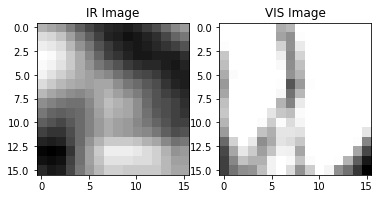

In [7]:
i = np.random.randint(len(trainSet)) # a random sample from the first batch

d = trainSet.dataset

img1, img2, label = d[i][0][0], d[i][0][1], d[i][1]

CHANNELS, DIM, DIM = img1.shape
TOTAL_PIXELS = DIM*DIM
print(img1.shape)

plt.subplot(1, 2, 1)
plt.imshow(img1.view(DIM, DIM), cmap='gray') # Reshaping x from (1, DIM, DIM) --> (DIM, DIM)
plt.title('IR Image')

plt.subplot(1, 2, 2)
plt.imshow(img2.view(DIM, DIM), cmap='gray') # Reshaping x from (1, DIM, DIM) --> (DIM, DIM)
plt.title('VIS Image')

print('Sample Number :', i)
print('Label         :', label.item())

# 0 --> not same
# 1 --> same

# Creating the Net

In [0]:
class Net(nn.Module):
  def __init__(self):
    super().__init__()


    # Creating the convulutional Layers
    self.conv1 = nn.Conv2d(in_channels=CHANNELS, out_channels=64, kernel_size=3, stride=1)
    self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1)
    self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1)

    self.flatten = None
    # Creating a Random dummy sample to get the Flattened Dimensions
    x = torch.randn(CHANNELS, DIM, DIM).view(-1, CHANNELS, DIM, DIM)
    x = self.convs(x)

    # Creating the Linear Layers
    # print('total', TOTAL_PIXELS)
    self.fc1   = nn.Linear(self.flatten, 256)
    self.fc2   = nn.Linear(256, 2)

  def convs(self, x):
    # Creating the MaxPooling Layers
    x = F.relu(self.conv1(x))
    x = F.max_pool2d(F.relu(self.conv2(x)), kernel_size=(3, 3), stride=2)
    x = F.relu(self.conv3(x))
    # print(x.shape)

    if not self.flatten:
      self.flatten = x[0].shape[0] * x[0].shape[1] * x[0].shape[2]
      # print('flatten', self.flatten)
    return x

  def get_sim_score(self, img1, img2):
    return F.pairwise_distance(img1.view(-1,  1), img2.view(-1,  1), keepdim=True).float()

  
  # FORWARD PASS
  def forward(self, x):

    features = {}
    for img, type_ in zip(x, ['IR', 'VIS']):
      img = img.to(device)
      img = self.convs(img)
      img = img.view(self.flatten, -1)
      features[type_] = img

    ir_slice = features['IR']
    vis_slice = features['VIS']
    # print(ir_slice.shape)
    
    # CONCATINATION
    # Getting the Euclidian Distance
    edist = self.get_sim_score(ir_slice, vis_slice)

    edist = edist.view(-1, self.flatten) # self.flatten = 2304
    # print('sm', sm.shape)

    sm = F.relu(self.fc1(edist))
    # print(fc1)
    label = self.fc2(sm)
    # print(label.shape)

    return label, sm

## Defining Training and Testing functions

In [0]:
def train(net, train_set, loss_log=[], lr_log=[], EPOCHS=5, LEARNING_RATE=0.001, BATCH_SIZE=32):
  print('Initiating Training..')  
  loss_func = nn.CrossEntropyLoss()

  # Iteration Begins
  for epoch in tqdm_notebook(range(EPOCHS)):
    # Iterate over every sample in the batch
    for data in tqdm_notebook(trainSet, desc=f'Iteration > {epoch+1}/{EPOCHS} : ', leave=False):
        x, y = data
        net.zero_grad()
        
        #Compute the output
        # output, sm = net(x.view(-1, CHANNELS, DIM, DIM).to(device))
        # global output
        output, sm = net(x)

        # print('2-Class output :', output)

        # Compute Train Loss
        loss = loss_func(output, y.to(device))
        
        # Backpropagate
        loss.backward()
        
        # Update Parameters
        optimizer.step()

        # LEARNING_RATE -= LEARNING_RATE*0.0005

    loss_log.append(loss)
    lr_log.append(LEARNING_RATE)
  
  return loss_log, lr_log



def test(net, test_set, find_accuracy=True):
  print('Initiating Testing..')
  correct = 0
  total   = 0
  accuracy = 0
  sm_log = []

  with torch.no_grad():
    for data in tqdm_notebook(test_set):
      x, y = data

      # Prediction the TestSet Data
      # prediction_in_batch, sm = net(x.view(-1, CHANNELS, DIM, DIM).to(device))
      prediction_in_batch, sm = net(x)

      # ARGMAXing the predicted output
      for output in zip(prediction_in_batch, y, sm):
        pred_class, real_class, sm = output
        pred_class = torch.argmax(pred_class)

        sm_log.append([sm, real_class])

        if find_accuracy:
          total += 1
          if real_class == pred_class:
            correct += 1

  if find_accuracy:
    accuracy = (correct/total)*100
    print()
    print(f'Test Accuracy : {round(accuracy, 2)} %')
  
  return accuracy, sm_log

# Training

### Load a model

In [10]:
PATH = '/content/drive/My Drive/Colab Notebooks/siamese_paper/'
MODEL_NAME = 'thebestsofar'

net = torch.load(PATH+MODEL_NAME)
net.eval()

Net(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=2304, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=2, bias=True)
)

### Train from Scratch

Initiating Training..



Total Epochs : 40


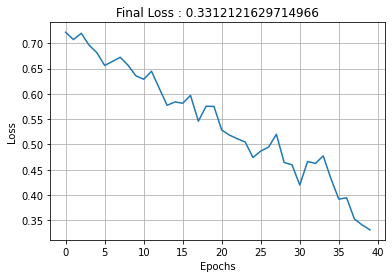

In [19]:
EPOCHS        = 40
LEARNING_RATE = 0.00005
BATCH_SIZE    = BATCH_SIZE
CONTINUE_TRAINING = 0

if not CONTINUE_TRAINING:
  net = Net().to(device)
  optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)

  loss_log = []
  lr_log   = []
  total_epochs = 0


total_epochs += EPOCHS
loss_log, lr_log = train(net, trainSet, loss_log, lr_log, EPOCHS, LEARNING_RATE, BATCH_SIZE)

plt.plot(loss_log)
plt.grid(1)
plt.title(f'Final Loss : {loss_log[-1]}')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# accuracy, sm_log = test(net, testSet, find_accuracy=True)

print(f'Total Epochs : {total_epochs}')

In [11]:
TRAIN_ACC, sm_log = test(net, trainSet, find_accuracy=True)
TEST_ACC, sm_log = test(net, testSet, find_accuracy=True)

Initiating Testing..




Test Accuracy : 80.66 %
Initiating Testing..




Test Accuracy : 82.3 %


## Saving the model

In [0]:
# PATH = '/content/drive/My Drive/Colab Notebooks/siamese_paper/'
# NAME = 'thebestsofar'
# torch.save(net, PATH+NAME)

# Testing

## Creating a Dataset
(of all positives)

In [0]:
data_path = '/content/drive/My Drive/Colab Notebooks/siamese_paper/dataset/custom_testing/'
os.chdir(data_path)

SLICE = 16
IMAGE_PAIR_NUMBER = 2

dataset = []


##### Reading the Images #####
ir_img  = plt.imread(f'IR_{IMAGE_PAIR_NUMBER}.bmp')
vis_img = plt.imread(f'VIS_{IMAGE_PAIR_NUMBER}.bmp')

row, col = ir_img.shape
# print('Image Original Dimensions :', ir_img.shape)

##### Resizing the Images #####
ir_img  = resize_image(ir_img,  row, col, slice=SLICE)
vis_img = resize_image(vis_img, row, col, slice=SLICE)

# print('Image Resized Dimensions  :', ir_img.shape)
ROW, COL = ir_img.shape


##### Slicing the images #####
ir_slices = []
vis_slices = []

ir_slices  = get_slice_list(ir_img, SLICE)
vis_slices = get_slice_list(vis_img, SLICE)


##### Zipping the two slices in tensor format, and adding the label ####
for ir_slice, vis_slice in zip(ir_slices, vis_slices):
  
  # Adding a Batch-Dimension
  ir_slice  = ir_slice[None, :, :]
  vis_slice = vis_slice[None, :, :]
  
  # Converting to Tensor
  features  = [torch.Tensor(ir_slice), torch.Tensor(vis_slice)]

  # Add the zip to the main dataset
  dataset.append([features, torch.tensor(1)]) # Giving the Label=1 because they're all positive examples.

# np array =
# dataset
#       |
#       |- features
#       |         |
#       |         |- ir_slice
#       |         |- vis_slice
#       |
#       |- label (1)

In [0]:
# using the testSet instead with BATCH_SIZE=1

BATCH_SIZE = 1
testSet  = torch.utils.data.DataLoader(dataset,  batch_size=BATCH_SIZE, shuffle=False)

## Testing

In [0]:
def get_map(net, test_set):
  print('Initiating Testing..')

  softmax = torch.nn.Softmax()

  sm_log = []
  dist_log = []

  with torch.no_grad():
    for data in tqdm_notebook(test_set):
      x, y = data

      # Prediction the TestSet Data
      
      output, sm = net(x)

      prob_distribution = softmax(output)

      sm_log.append(sm)
      dist_log.append(prob_distribution.cpu().numpy())

  return sm_log, dist_log

In [122]:
# Feeding the dataset(s) to the Network -> returns the respective output
sm_log, dist_log  = get_map(net, testSet) #testSet > dataset of all the patches of a single image

Initiating Testing..


In [0]:
# Just fusing and plotting one sample

SAMPLE = 150

ir_patch    = testSet.dataset[SAMPLE][0][0].view(16, 16)
vis_patch   = testSet.dataset[SAMPLE][0][1].view(16, 16)
ir_w, vis_w = dist_log[SAMPLE][0]

fused = ir_patch * ir_w + vis_patch * vis_w

Text(0.5, 1.0, 'Fused')

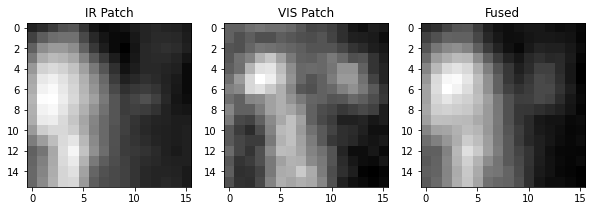

In [124]:
plt.figure(figsize=(10, 10))

plt.subplot(1, 3, 1)
plt.imshow(ir_patch, cmap='gray')
plt.title('IR Patch')

plt.subplot(1, 3, 2)
plt.imshow(vis_patch, cmap='gray')
plt.title('VIS Patch')


plt.subplot(1, 3, 3)
plt.imshow(fused, cmap='gray')
plt.title('Fused')

In [0]:
# Fusing all the patch pairs
fused_patches = []
for i in range(len(testSet)):
  ir_patch    = testSet.dataset[i][0][0].view(16, 16)
  vis_patch   = testSet.dataset[i][0][1].view(16, 16)
  ir_w, vis_w = dist_log[i][0]

  fused = ir_patch * vis_w + vis_patch * ir_w
  fused_patches.append(fused.cpu().numpy())

In [0]:
def unblockshaped(arr, h, w):
    """
    Return an array of shape (h, w) where
    h * w = arr.size

    If arr is of shape (n, nrows, ncols), n sublocks of shape (nrows, ncols),
    then the returned array preserves the "physical" layout of the sublocks.
    """
    n, nrows, ncols = arr.shape
    return (arr.reshape(h//nrows, -1, nrows, ncols)
               .swapaxes(1,2)
               .reshape(h, w))

In [0]:
# Creating the Fused Image
fused_image = unblockshaped(np.array(fused_patches), ROW, COL)

Text(0.5, 1.0, 'FUSED Image')

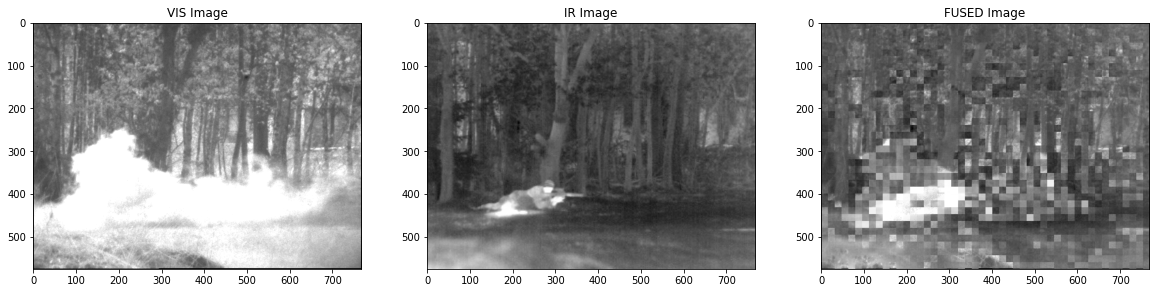

In [132]:
plt.figure(figsize=(20, 20))

plt.subplot(1, 3, 1)
plt.imshow(vis_img, cmap='gray')
plt.title('VIS Image')

plt.subplot(1, 3, 2)
plt.imshow(ir_img, cmap='gray')
plt.title('IR Image')

plt.subplot(1, 3, 3)
plt.imshow(fused_image, cmap='gray')
plt.title('FUSED Image')

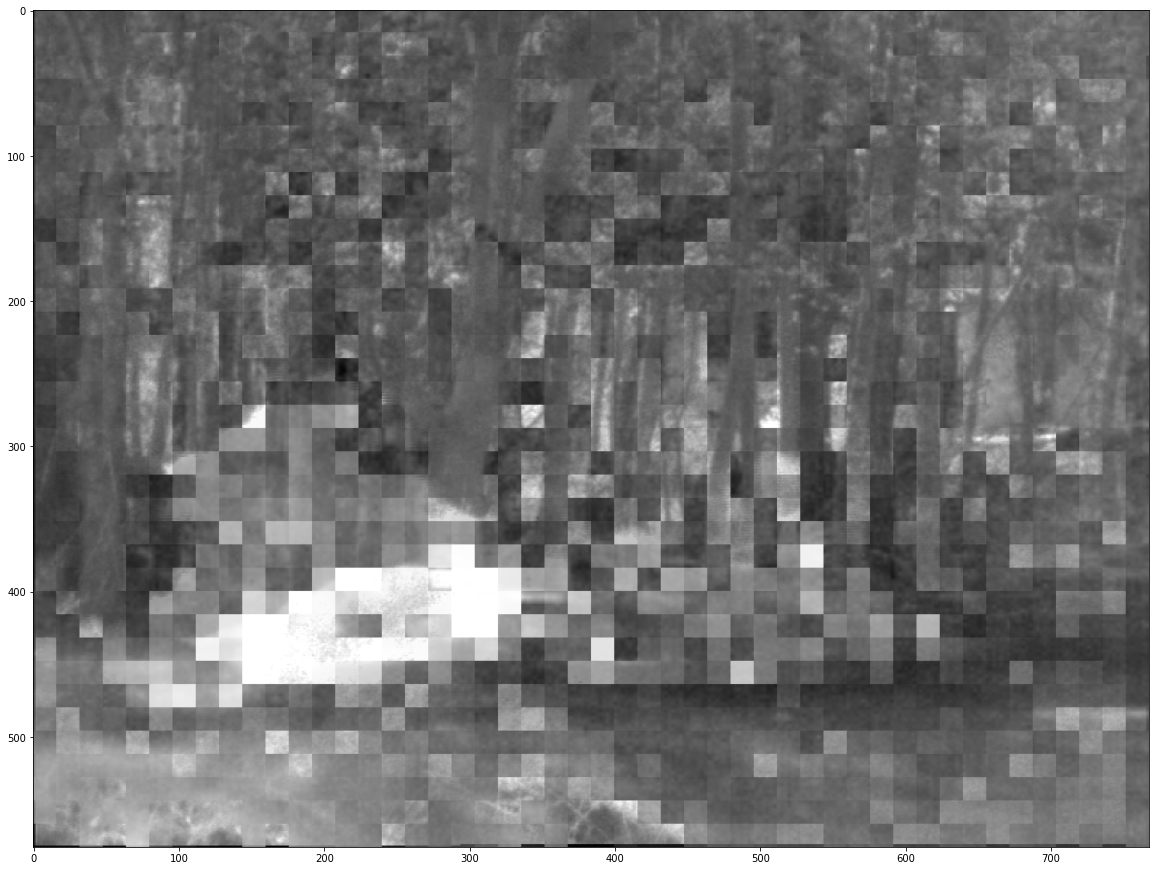

In [133]:
plt.figure(figsize=(20, 20))
plt.imshow(fused_image, cmap='gray')

# Reverse Max Pooling

In [0]:
def reverse_pool(final_shape, slice_arr, patch_length, stride):

  ROWS, COLS = final_shape

  papa = np.zeros((ROWS, COLS))

  for row, slice_ in zip(range(patch_length, ROWS+1, stride), slice_arr):
    for col in range(patch_length, COLS+1, stride):
      row_low, row_high = row-patch_length, row
      col_low, col_high = col-patch_length, col

      WINDOW = papa[row_low:row_high, col_low:col_high]

      papa[row_low:row_high, col_low:col_high] = np.where(WINDOW!=0, (WINDOW + slice_)/2, slice_)

  return papa

In [0]:
FINAL_SHAPE = ir_img.shape
STRIDE = 2
PATCH = 16
SLICE_ARR = []
for i in range(len(dist_log)):
  prob = dist_log[i][0][0]

  patch_map = np.ones((16, 16))*prob
  
  SLICE_ARR.append(patch_map)

# Generating the Reversed-pool MAP
main_map = reverse_pool(final_shape=FINAL_SHAPE, slice_arr=SLICE_ARR, patch_length=PATCH, stride=STRIDE)

# Fusing the images according to the map
main = main_map*vis_img + (1-main_map)*ir_img

Text(0.5, 1.0, 'FUSED Image')

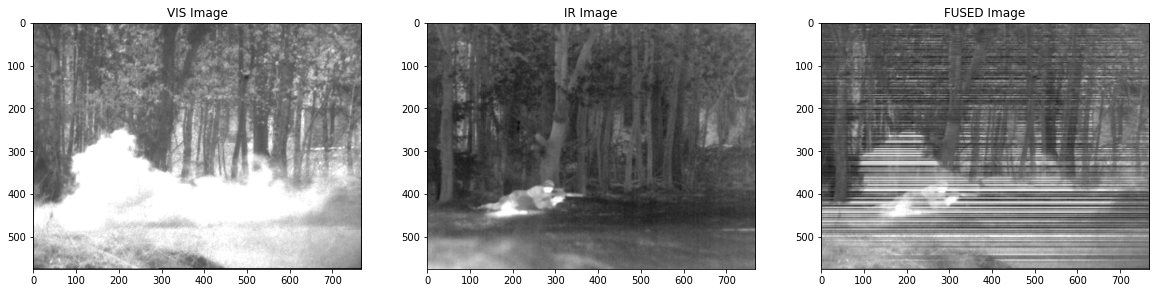

In [136]:
plt.figure(figsize=(20, 20))

plt.subplot(1, 3, 1)
plt.imshow(vis_img, cmap='gray')
plt.title('VIS Image')

plt.subplot(1, 3, 2)
plt.imshow(ir_img, cmap='gray')
plt.title('IR Image')

plt.subplot(1, 3, 3)
plt.imshow(main, cmap='gray')
plt.title('FUSED Image')

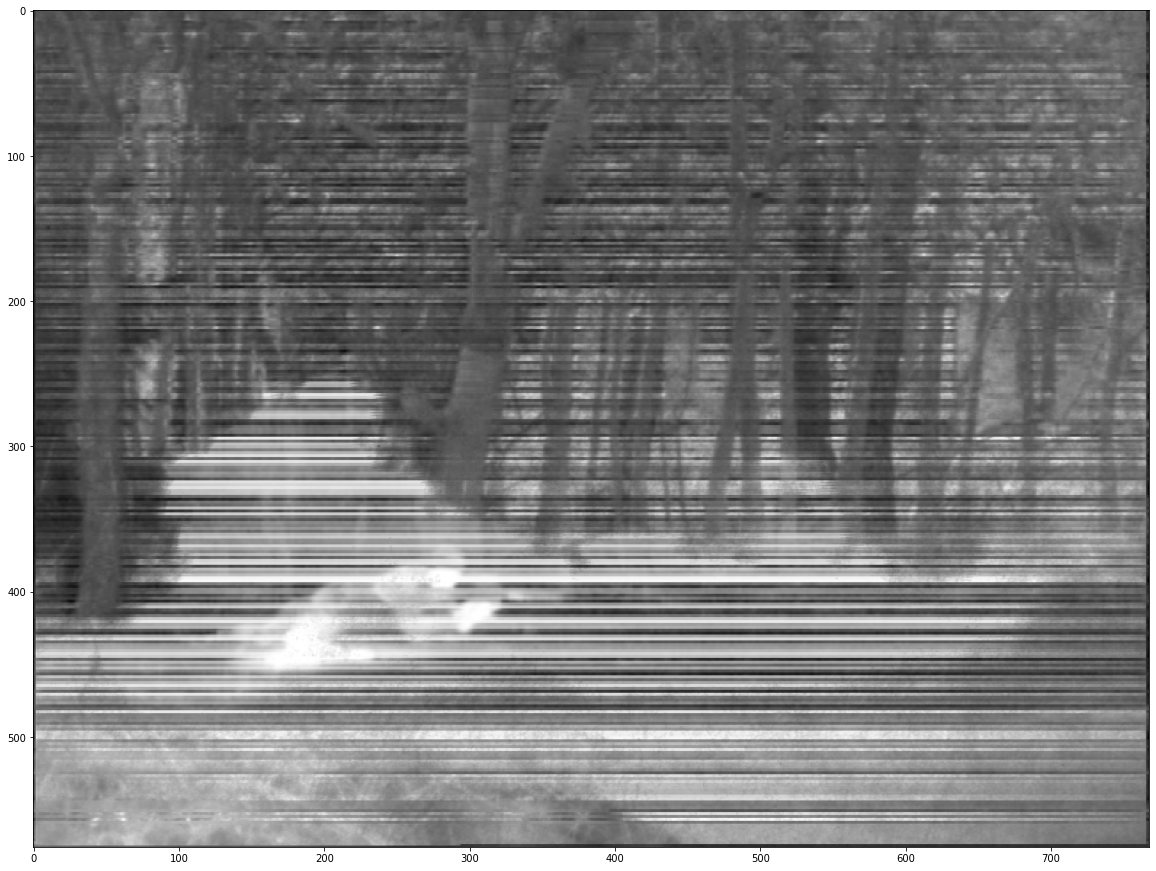

In [137]:
plt.figure(figsize=(20, 20))
plt.imshow(main, cmap='gray')